In [13]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as ln
import scipy as sp
from math import sqrt

In [2]:
def func(arr):
    x = arr[0]
    y = arr[1]
    return 100*(y-x**2)**2 + (1-x)**2

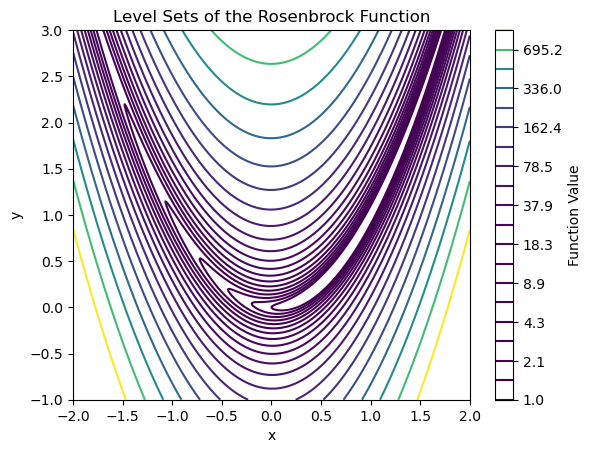

In [3]:
xgrids = np.linspace(-2, 2, 400)
ygrids = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(xgrids, ygrids)

# Calculate the function values for each (x, y) pair
Z = func([X, Y])

# Create a contour plot
plt.figure()
contour = plt.contour(X, Y, Z, levels=np.logspace(0, 3, 20), cmap='viridis')
plt.colorbar(contour, label='Function Value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Level Sets of the Rosenbrock Function')
plt.show()

In [4]:
def gradf(arr):
    x = arr[0]
    y = arr[1]
    dx = -400*x*(y-x**2) - 2*(1-x)
    dy = 200*(y-x**2)
    res = np.array([dx, dy])
    
    return res

In [5]:
def hessianf(arr):
    x = arr[0]
    y = arr[1]
    res = np.zeros((2, 2))
    dxx = 800*x**2 - 400*(y-x**2) + 2
    dxy = -400*x
    dyy = 200
    res[0, 0] = dxx
    res[0, 1] = dxy
    res[1, 0] = dxy
    res[1, 1] = dyy
    
    return res

In [6]:
# solution
xstar = 1
ystar = 1
pointstar = [xstar, ystar]

In [7]:
print("Gradient value:")
gradf(pointstar)

Gradient value:


array([0, 0])

In [8]:
print("Hessian is SPD or not:")
np.all(np.linalg.eigvals(hessianf(pointstar)) > 0)

Hessian is SPD or not:


True

In [135]:
# initial condition
x = -1.2
y = 1
point = np.array([x, y])


# set configurations
tol = 1e-6 # stop iterations when ||grad f|| < tol
iter_max = 1000 # the maximal number of iterations
draw_flag = 1 # if draw_flag = 1, draw configuration at every iteration
tol_sub = 1e-1 # relative tolerance for the subproblem
subproblem_iter_max = 5 # the max # of iteration for quadratic subproblems


# parameters for backtracking line search
c = 0.5;
rho = 0.9;

In [52]:
def cauchy_point(B,g,Delta):
    ng = np.linalg.norm(g)
    ps = -g*Delta/ng
    aux = np.dot(g,B @ g)
    if( aux <= 0 ):
        p = ps
    else:
        a = np.minimum(ng**3/(Delta*aux),1)
        p = ps*a
    return p

In [55]:
def dogleg_method(Hk, gk, Bk, trust_radius):
    pB = -np.dot(Hk, gk)
    norm_pB = sqrt(np.dot(pB, pB))
    
    # Test if the full step is within the trust region.
    if norm_pB <= trust_radius:
        return pB
    
    # Compute the Cauchy point.
    # This is the predicted optimum along the direction of steepest descent.
    pU = - (np.dot(gk, gk) / np.dot(gk.T, np.dot(Bk, gk))) * gk
    dot_pU = np.dot(pU, pU)
    norm_pU = sqrt(dot_pU)
    # If the Cauchy point is outside the trust region,
    # then return the point where the path intersects the boundary
    if norm_pU >= trust_radius:
        return trust_radius * pU / norm_pU
    
    # Find the solution to the scalar quadratic equation
    # Compute the intersection of the trust region boundary
    # and the line segment connecting the Cauchy and Newton points
    # This requires solving a quadratic equation
    # ||p_u + tau*(p_b - p_u)||**2 == trust_radius**2
    # Solve this for positive time t using the quadratic formula
    pB_pU = pB - pU
    dot_pB_pU = np.dot(pB_pU, pB_pU)
    dot_pU_pB_pU = np.dot(pU, pB_pU)
    fact = dot_pU_pB_pU**2 - dot_pB_pU * (dot_pU - trust_radius**2)
    tau = (-dot_pU_pB_pU + sqrt(fact)) / dot_pB_pU
    # Decide on which part of the trajectory to take
    return pU + tau * pB_pU

In [113]:
def newton(B, g, Delta):
    # check if B is SPD
    eval_min = np.amin(np.real(sp.linalg.eig(B, b=None, left=False, right=False)))
    flag_boundary = 0
    j_sub = 0
    if( eval_min > 0 ): # B is SPD: B = R'*R, R'*R*p = -g 
        p = sp.linalg.solve(B,-g)
        p_norm = np.linalg.norm(p)
        if( p_norm > Delta ): # else: we are done with solbing the subproblem
            flag_boundary = 1        
    else: # B is not SPD
        flag_boundary = 1
        
    if( flag_boundary == 1 ): # solution lies on the boundary
        # added to B to ensure it is SPD
        lam_min = np.maximum(-eval_min,0.0)
        lam = lam_min + 1
        
        I = np.eye(np.size(B[0]),dtype = float)
        R = sp.linalg.cholesky(B+lam*I,lower = False)
        flag_subproblem_success = 0;
        while( j_sub < subproblem_iter_max ):
            j_sub = j_sub + 1;
            p = sp.linalg.solve_triangular(np.transpose(R),-g,lower = True)
            p = sp.linalg.solve_triangular(R,p,lower = False)
            p_norm = np.linalg.norm(p)
            dd = np.absolute(p_norm - Delta)
            if( dd < tol_sub*Delta ):
                flag_subproblem_success = 1
                break
            q = sp.linalg.solve_triangular(np.transpose(R),p,lower = True)
            q_norm = np.linalg.norm(q);
            dlam = ((p_norm/q_norm)**2)*(p_norm - Delta)/Delta
            lam_new = lam + dlam;
            if (lam_new > lam_min):
                lam = lam_new
            else:
                lam = 0.5*(lam + lam_min)
            R = sp.linalg.cholesky(B+lam*I,lower = False)
            
        if( flag_subproblem_success == 0 ):
            p = cauchy_point(B,g,Delta)
    
    return p, j_sub

In [121]:
def trust_region(func, gradf, hessianf, point, initial_trust_radius=1.0,
                        max_trust_radius=5.0, eta=0.1, gtol=1e-6, 
                        maxiter=200):
    xk = point
    x_arr = []
    p_arr = []
    diffvals = []
    
    trust_radius = initial_trust_radius
    k = 0
    while True:
        gk = gradf(xk)
        Bk = hessianf(xk)
        Hk = np.linalg.inv(Bk)
#         pk = dogleg_method(Hk, gk, Bk, trust_radius)
        pk, j_sub = newton(Bk, gk, trust_radius)
        
        # store values for plotting purpose
        x_arr.append(xk)
        p_arr.append(pk)
        diffvals.append(ln.norm(xk - pointstar))
         
        # Actual reduction
        act_red = func(xk) - func(xk + pk)
        # Predicted reduction
        pred_red = - (np.dot(gk, pk) + 0.5 * np.dot(pk, np.dot(Bk, pk)))
        rhok = act_red / pred_red

            
        # Calculate the Euclidean norm of pk
        norm_pk = sqrt(np.dot(pk, pk))
        # Rho is close to zero or negative, therefore the trust region is shrunk
        if rhok < 0.25:
            trust_radius = 0.25 * norm_pk
            
        else: 
        # Rho is close to one and pk has reached the boundary of the trust region, 
        # therefore the trust region is expanded
            if rhok > 0.75 and norm_pk == trust_radius:
                trust_radius = min(2.0*trust_radius, max_trust_radius)

        # Choose the position for the next iteration.
        if rhok > eta:
            xk = xk + pk
            print("Accept", j_sub)
        else:
            xk = xk
            print("Reject", j_sub)
            
        # Check if the gradient is small enough to stop
        if ln.norm(gk) < gtol:
            break
            
        # Check if we have looked at enough iterations
        if k >= maxiter:
            break
        k = k + 1
        
    return xk, x_arr, p_arr, diffvals

In [136]:
result, x_arr, p_arr, diffvals = trust_region(func, gradf, hessianf, point)
print("Result of trust region dogleg method: {}".format(result))
print("Value of function at a point: {}".format(func(result)))

Accept 0
Reject 2
Accept 2
Accept 2
Accept 2
Accept 2
Accept 2
Accept 2
Accept 2
Accept 0
Accept 1
Accept 0
Accept 2
Accept 2
Accept 2
Accept 2
Accept 2
Accept 2
Accept 2
Accept 2
Accept 2
Accept 2
Accept 2
Accept 2
Accept 2
Accept 1
Accept 2
Accept 2
Accept 0
Accept 0
Accept 0
Accept 0
Accept 0
Result of trust region dogleg method: [1. 1.]
Value of function at a point: 0.0


In [108]:
x_arr

[array([-1.2,  1. ]),
 array([-0.27414729,  1.37789223]),
 array([-0.74829212,  0.49743811]),
 array([0.12301799, 0.98827148]),
 array([0.37016091, 0.01929014]),
 array([-0.19609687,  0.84353686]),
 array([-0.54914653, -0.09207182]),
 array([-0.54914653, -0.09207182]),
 array([-0.36137221,  0.07298146]),
 array([-0.18833555,  0.2534377 ]),
 array([-0.26499555,  0.0154792 ]),
 array([-0.11360404,  0.21444531]),
 array([-0.15597105, -0.03194042]),
 array([-0.04110942,  0.19012445]),
 array([-0.04784808, -0.05978663]),
 array([0.01605768, 0.18191713]),
 array([ 0.03754995, -0.06715963]),
 array([0.05381116, 0.18231918]),
 array([ 0.09339779, -0.06452941]),
 array([0.07765232, 0.18498221]),
 array([ 0.12829537, -0.05983757]),
 array([0.09304733, 0.18767304]),
 array([ 0.15064831, -0.05560385]),
 array([0.10329716, 0.18987889]),
 array([ 0.16544509, -0.05227644]),
 array([0.1102918 , 0.19157189]),
 array([ 0.17550166, -0.04977698]),
 array([0.11515187, 0.19283749]),
 array([ 0.18246914, -0.

In [57]:
# start minimization
# choose algorithm
# direction = 0: steepest descent
# direction = 1: Newton
# direction = 2: BFGS
# direction = 3: FRCG
# direction = 4: PRCG
direction = 2


f = func(point)
g = gradf(point)
norm_g = np.linalg.norm(g)
print("Initially, f = ",f,", ||grad f|| = ",norm_g)

fvals = np.zeros(iter_max)
fvals[0] = f
ngvals = np.zeros(iter_max)
ngvals[0] = norm_g
diffvals = np.zeros(iter_max)
diffvals[0] = np.linalg.norm(point - pointstar)

iter = 1

# new variables
d = len(point)
x_arr = []
g_arr = []
p_arr = []
a_arr = []
x_arr.append(point)
g_arr.append(g)
a_arr.append(1)
B = np.eye(d)
found_spd = False

while (norm_g > tol and iter < iter_max): 
    #choose search direction
    if( direction == 0): # steepest descent
        p = -g
        dir = "SD"
    
    elif( direction == 1): # Newton
        H = hessianf(point)
#         print(np.linalg.eigvals(H))
        spd = np.all(np.linalg.eigvals(H) > 0)
        if( spd ): # H is SPD, use Newton's direction
            p = np.linalg.solve(H,-g) 
            dir = "Newton"
        else: # use the steepest descent direction
            p = -g
            dir = "SD";
    
    elif (direction == 2): # BFGS
        # initial Hessian
        if found_spd==False:
            B = np.eye(d)
            p = np.linalg.solve(B,-g) 
            found_spd = True
            dir = "BFGS (initialize)"
            
        # update Hessian
        else:
            # reset B matrix
            if iter%20 == 0:
                B = np.eye(d)
            
            y = g_arr[-1] - g_arr[-2]
            y = np.array([y])
            s = np.array(x_arr[-1] - x_arr[-2])
            y = np.reshape(y,(d,1))
            s = np.reshape(s,(d,1))
            
            r = 1/(y.T@s)
            rterm = r*(y@y.T)
            l = 1/(s.T@B@s)
            lterm = l*(B@s@s.T@B)
            
            B = B - lterm + rterm
            p = np.linalg.solve(B,-g) 
            dir = "BFGS"
    
    elif (direction == 3): # FRCG
        if (len(x_arr) == 1): # steepest descent
            p = -g
            dir = "SD"
        
        else:
            gkplus1 = g_arr[-1]
            gk = g_arr[-2]
            numerator = gkplus1.T@gkplus1
            denominator = gk.T@gk
            beta = numerator / denominator
            p = beta*p - gkplus1
            dir = "FRCG"
            
    elif (direction == 4): # PRCG
        if (len(x_arr) == 1): # steepest descent
            p = -g
            dir = "SD"
        
        else:
            gkplus1 = g_arr[-1]
            gk = g_arr[-2]
            numerator = gkplus1.T@(gkplus1 - gk)
            denominator = gk.T@gk
            beta = max(numerator / denominator, 0)
            p = beta*p - gkplus1
            dir = "PRCG"
    
    else:
        print("direction is out of range")
        break
        
    # normalize the search direction if its length greater than 1
    norm_p = np.linalg.norm(p)
    if( norm_p > 1):
        p = p/norm_p
        
    # do backtracking line search along the direction p
    a = 1 # initial step length
    f_temp = func(point + a*p)
    cpg = c*np.dot(p,g)
#     print("cpg = ",cpg,"f = ",f,"f_temp = ",f_temp)

    while( f_temp > f + a*cpg ): # check Wolfe's condition 1
        a = a*rho
        if( a < 1e-14 ):
            print("line search failed\n");
            iter = iter_max-1
            break
        f_temp = func(point + a*p)        
#         print("f_temp = ",f_temp)

    point = point + a*p
    f = func(point)
    g = gradf(point)
    
    # new added
    x_arr.append(point)
    g_arr.append(g)
    a_arr.append(a)
    p_arr.append(a*p)
    
    norm_g = np.linalg.norm(g)
#     print("iter ",iter,": dir = ",dir,", f = ",f,", ||grad f|| = ",norm_g,", step length = ",a)
    print(f"iter {iter}: dir = {dir}, f = {f:.6f}, ||grad f|| = {norm_g:.6e}, step length = {a:.3e}")

    fvals[iter] = f
    ngvals[iter] = norm_g
    diffvals[iter] = np.linalg.norm(point - pointstar)
    iter = iter + 1
print(f"Result: f = {f:.10f}, ||grad f|| = {norm_g:.6e}")
    

Initially, f =  5.8 , ||grad f|| =  125.16932531574977
iter 1: dir = BFGS (initialize), f = 0.040410, ||grad f|| = 8.184542e+00, step length = 8.863e-02
iter 2: dir = BFGS, f = 0.021731, ||grad f|| = 2.224742e+00, step length = 5.314e-01
iter 3: dir = BFGS, f = 0.013849, ||grad f|| = 9.473752e-01, step length = 1.000e+00
iter 4: dir = BFGS, f = 0.005697, ||grad f|| = 2.803706e+00, step length = 1.000e+00
iter 5: dir = BFGS, f = 0.002521, ||grad f|| = 6.983039e-01, step length = 1.000e+00
iter 6: dir = BFGS, f = 0.000557, ||grad f|| = 3.381469e-01, step length = 1.000e+00
iter 7: dir = BFGS, f = 0.000082, ||grad f|| = 3.432093e-01, step length = 1.000e+00
iter 8: dir = BFGS, f = 0.000004, ||grad f|| = 3.437418e-03, step length = 9.000e-01
iter 9: dir = BFGS, f = 0.000000, ||grad f|| = 7.912114e-03, step length = 9.000e-01
iter 10: dir = BFGS, f = 0.000000, ||grad f|| = 8.821616e-05, step length = 1.000e+00
iter 11: dir = BFGS, f = 0.000000, ||grad f|| = 1.061985e-06, step length = 1.000

Text(0.5, 1.0, '$||(x_{k}, y_{k}) - (x^{*}, y^{*}) ||$ versus k in logarithmic scale')

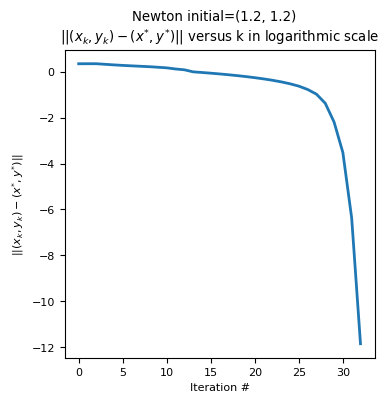

In [127]:
fig, (ax1) = plt.subplots(1, 1, figsize=(4,4))
# fig.tight_layout(pad=5)
plt.rcParams.update({'font.size': 8})
plt.suptitle("Newton initial=(1.2, 1.2)")
# ax1.figure(figsize=(8,8))
ax1.plot(np.arange(len(diffvals)),np.log10(diffvals),linewidth = 2)
ax1.set_xlabel("Iteration #")
ax1.set_ylabel(r'$||(x_{k}, y_{k}) - (x^{*}, y^{*}) ||$')
ax1.set_title(r'$||(x_{k}, y_{k}) - (x^{*}, y^{*}) ||$ versus k in logarithmic scale')

# ax2.plot(np.arange(iter), a_arr,linewidth = 2)
# ax2.set_xlabel("Iteration #")
# ax2.set_ylabel(r'$\alpha_{k}$')
# ax2.set_title(r'$\alpha_{k}$ versus k')

In [34]:
len(a_arr), len(x_arr)

(32, 32)

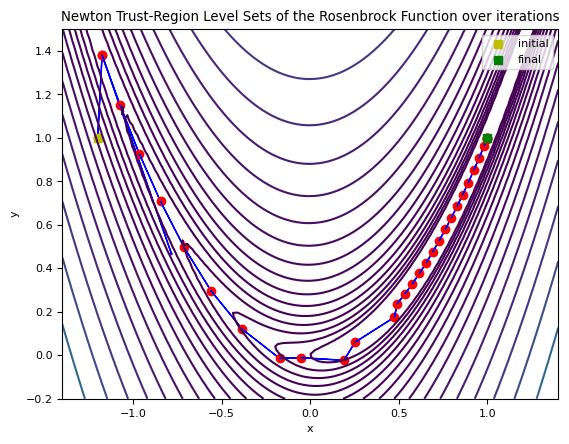

In [139]:
xgrids = np.linspace(-1.4, 1.4, 100)
ygrids = np.linspace(-0.2, 1.5, 100)
X, Y = np.meshgrid(xgrids, ygrids)

# Calculate the function values for each (x, y) pair
Z = func([X, Y])

# Create a contour plot
plt.figure()
contour = plt.contour(X, Y, Z, levels=np.logspace(0, 3, 20), cmap='viridis')
# plt.colorbar(contour, label='Function Value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Newton Trust-Region Level Sets of the Rosenbrock Function over iterations')

# drawing the steps on contour map
for point, p in zip(x_arr, p_arr):
    plt.scatter(point[0], point[1], color='red', marker='o') #, label=f'Iteration {iteration + 1}'
    plt.arrow(point[0], point[1], p[0], p[1], head_width=0.008, head_length=0.008, 
              length_includes_head=True, fc='blue', ec='blue')

plt.scatter(x_arr[0][0], x_arr[0][1], color='y', marker=',', label=f'initial')
plt.scatter(x_arr[-1][0], x_arr[-1][1], color='g', marker=',', label=f'final')
plt.legend()
    
plt.show()